# Clasificación de Comentarios por Departamento

## Arquitectura del Sistema

Este notebook implementa un clasificador de comentarios del buzón institucional usando técnicas de **Few-Shot Learning**:

1. **FlashText** - Clasificación rápida por palabras clave (O(N))
2. **SetFit** - Entrenamiento contrastivo con pocos ejemplos
3. **Anchoring** - Descripciones de departamentos como anclas semánticas
4. **ONNX + INT8** - Optimización para inferencia rápida
5. **Umbral Coseno** - Detección de incertidumbre (OOD)

**Modelo Base**: `paraphrase-multilingual-MiniLM-L12-v2` (óptimo para español)

In [38]:
# Instalación de dependencias (ejecutar una vez)
# !pip install setfit sentence-transformers flashtext onnx onnxruntime optimum[onnxruntime] -q

In [39]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
from collections import defaultdict

# Sentence Transformers y SetFit
from sentence_transformers import SentenceTransformer
from setfit import SetFitModel, Trainer, TrainingArguments

# FlashText para búsqueda rápida de palabras clave
from flashtext import KeywordProcessor

# Métricas
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

print("✅ Librerías cargadas correctamente")

✅ Librerías cargadas correctamente


## 2. Carga de Datos

Cargamos los comentarios etiquetados y las descripciones de funciones de cada departamento que servirán como **anclas semánticas**.

In [40]:
# Rutas de archivos
carpeta_raiz = Path.cwd().parent

ruta_comentarios = Path("dataset_comentarios.json")
ruta_departamentos = Path("departamentos_funcion.json")

# Validar existencia de archivos
for ruta in [ruta_comentarios, ruta_departamentos]:
    if not ruta.exists():
        raise FileNotFoundError(f"No se encontró: {ruta}")

# Cargar datos
with open(ruta_comentarios, "r", encoding="utf-8") as f:
    comentarios_data = json.load(f)

with open(ruta_departamentos, "r", encoding="utf-8") as f:
    departamentos_funcion = json.load(f)

# Convertir a DataFrame
df = pd.DataFrame(comentarios_data)
df = df.rename(columns={"instancia_unificada": "departamento"})

print(f"📊 Total de comentarios: {len(df)}")
print(f"🏛️ Departamentos encontrados: {df['departamento'].nunique()}")
print("\n📋 Distribución por departamento:")
print(df["departamento"].value_counts())

📊 Total de comentarios: 544
🏛️ Departamentos encontrados: 17

📋 Distribución por departamento:
departamento
Subdirección Administrativa                  32
Unidad Politécnica de Integración Social     32
Formación Integral e Institucional           32
Formación Básica                             32
Actividades Culturales y/o Deportivas        32
Recursos Materiales y Servicios Generales    32
Tecnología Educativa y Campus Virtual        32
Dirección                                    32
Servicios Estudiantiles                      32
Gestión Escolar                              32
Recursos Financieros                         32
Subdirección Académica                       32
Innovación Educativa                         32
Coordinación de Enlace y Gestión Técnica     32
Evaluación y Seguimiento Académico           32
Extensión y Apoyos Educativos                32
Unidad de Informática                        32
Name: count, dtype: int64


## 3. FlashText: Filtrado Rápido por Palabras Clave

FlashText proporciona búsqueda O(n) independiente del número de palabras clave. Esto permite una **primera capa de clasificación casi instantánea** para casos obvios.

In [41]:
# Diccionario de palabras clave por departamento
# Estas palabras activan clasificación directa sin usar el modelo
KEYWORDS_POR_DEPARTAMENTO = {
    "Subdirección Administrativa": [
        "aire acondicionado", "clima", "luz", "electricidad", "mantenimiento",
        "limpieza", "baños", "mobiliario", "sillas", "escritorios", "focos",
        "instalaciones", "cafetería", "comedor", "estacionamiento"
    ],
    "Gestión Escolar": [
        "constancia", "certificado", "credencial", "inscripción", "reinscripción",
        "baja", "kardex", "calificaciones", "historial académico", "titulación",
        "servicio social", "prácticas profesionales", "boleta"
    ],
    "Unidad de Informática": [
        "internet", "wifi", "red", "computadora", "sistema", "plataforma",
        "correo institucional", "password", "contraseña", "software", "impresora",
        "laboratorio de cómputo", "proyector"
    ],
    "Subdirección Académica": [
        "maestro", "profesor", "docente", "clase", "horario", "materia",
        "evaluación docente", "plan de estudios", "tutorías", "asesorías"
    ],
    "Dirección": [
        "director", "director general", "rectoría", "política institucional"
    ]
}

# Crear procesador FlashText
keyword_processor = KeywordProcessor(case_sensitive=False)

for departamento, keywords in KEYWORDS_POR_DEPARTAMENTO.items():
    for kw in keywords:
        keyword_processor.add_keyword(kw, departamento)

def clasificar_por_keywords(texto):
    """
    Intenta clasificar usando palabras clave.
    Retorna (departamento, confianza) si encuentra match, sino (None, 0.0)
    """
    matches = keyword_processor.extract_keywords(texto.lower())
    if matches:
        # Contar frecuencia de cada departamento mencionado
        freq = defaultdict(int)
        for dept in matches:
            freq[dept] += 1
        # Retornar el departamento más frecuente
        mejor_dept = max(freq, key=freq.get)
        return mejor_dept, 1.0  # Confianza alta para matches directos
    return None, 0.0

# Prueba rápida
texto_prueba = "El aire acondicionado del salón no funciona"
dept, conf = clasificar_por_keywords(texto_prueba)
print(f"Texto: '{texto_prueba}'")
print(f"Clasificación FlashText: {dept} (confianza: {conf})")

Texto: 'El aire acondicionado del salón no funciona'
Clasificación FlashText: Subdirección Administrativa (confianza: 1.0)


## 4. Preparación de Datos para SetFit

SetFit usa **Contrastive Learning**: aprende que comentarios del mismo departamento deben estar cerca en el espacio de embeddings, y los de diferentes departamentos deben estar lejos.

Preparamos:
1. **Anclas semánticas**: Las descripciones de funciones de cada departamento
2. **Pares de entrenamiento**: (comentario, etiqueta) con estratificación

In [42]:
# Crear anclas semánticas a partir de las descripciones de departamentos
print("🎯 Anclas Semánticas por Departamento:\n")
anclas = {}

# Agrupar funciones por departamento
for registro in departamentos_funcion:
    dept = registro["Departamento / Subdirección"]
    funcion = registro["Función"]
    
    # Acumular funciones por departamento
    if dept not in anclas:
        anclas[dept] = []
    anclas[dept].append(funcion)

# Convertir listas de funciones a descripciones concatenadas
for dept, funciones in anclas.items():
    descripcion = ". ".join(funciones)
    anclas[dept] = descripcion
    print(f"📌 {dept}:")
    print(f"   {descripcion[:100]}..." if len(descripcion) > 100 else f"   {descripcion}")
    print()

🎯 Anclas Semánticas por Departamento:

📌 Dirección:
   Coordina y da seguimiento a los procesos institucionales.. Verifica que los procesos se realicen con...

📌 UDI:
   Administra el préstamo de equipo de cómputo.

📌 Subdirección Académica:
   Selecciona y contrata docentes.. Asigna grupos, horarios y salones.. Impulsa mejoras en la enseñanza...

📌 Depto. Ing. Sistemas:
   Organiza contenidos y actividades de las materias.

📌 Depto. Ciencias e Ing. Computación:
   Coordina prácticas académicas.

📌 Gestión Escolar:
   Administra trámites escolares.

📌 Servicios Estudiantiles:
   Ofrece servicios culturales, deportivos y médicos.

📌 Subdirección Administrativa:
   Administra compras y mantenimiento.

📌 Recursos Financieros:
   Gestiona y controla recursos financieros.

📌 Capital Humano:
   Capacita al personal administrativo y directivo.



In [43]:
# Filtrar solo departamentos que tienen ejemplos en el dataset
departamentos_validos = df["departamento"].unique()
print(f"📂 Departamentos en dataset: {len(departamentos_validos)}")

# Mapear etiquetas a índices numéricos
label2id = {label: idx for idx, label in enumerate(sorted(departamentos_validos))}
id2label = {idx: label for label, idx in label2id.items()}

print("\n🏷️ Mapeo de etiquetas:")
for label, idx in label2id.items():
    print(f"  {idx}: {label}")

# Agregar columna de label numérico
df["label"] = df["departamento"].map(label2id)

# Dividir en train/test estratificado
# Para Few-Shot, usamos pocas muestras de entrenamiento (8-16 por clase)
SAMPLES_PER_CLASS = 25

train_dfs = []
test_dfs = []

for dept in departamentos_validos:
    dept_df = df[df["departamento"] == dept].copy()
    n_samples = len(dept_df)
    
    if n_samples >= SAMPLES_PER_CLASS + 2:  # Al menos algunas para test
        train_samples = dept_df.sample(n=min(SAMPLES_PER_CLASS, n_samples - 2), random_state=42)
        test_samples = dept_df.drop(train_samples.index)
    else:
        # Si hay muy pocos, usar 80/20
        train_samples = dept_df.sample(frac=0.8, random_state=42)
        test_samples = dept_df.drop(train_samples.index)
    
    train_dfs.append(train_samples)
    test_dfs.append(test_samples)

train_df = pd.concat(train_dfs, ignore_index=True)
test_df = pd.concat(test_dfs, ignore_index=True)

print(f"\n📊 Dataset dividido:")
print(f"  Train: {len(train_df)} ejemplos")
print(f"  Test: {len(test_df)} ejemplos")

# Diagnóstico: mostrar la distribución detallada
print("\n🔍 Distribución detallada por departamento:")
print(f"{'Departamento':<40} {'Total':>8} {'Train':>8} {'Test':>8}")
print("-" * 68)
for dept in sorted(departamentos_validos):
    total = len(df[df["departamento"] == dept])
    train = len(train_df[train_df["departamento"] == dept])
    test = len(test_df[test_df["departamento"] == dept])
    print(f"{dept:<40} {total:>8} {train:>8} {test:>8}")
    if test == 0:
        print(f"  ⚠️  ADVERTENCIA: Este departamento NO tiene ejemplos en test!")

📂 Departamentos en dataset: 17

🏷️ Mapeo de etiquetas:
  0: Actividades Culturales y/o Deportivas
  1: Coordinación de Enlace y Gestión Técnica
  2: Dirección
  3: Evaluación y Seguimiento Académico
  4: Extensión y Apoyos Educativos
  5: Formación Básica
  6: Formación Integral e Institucional
  7: Gestión Escolar
  8: Innovación Educativa
  9: Recursos Financieros
  10: Recursos Materiales y Servicios Generales
  11: Servicios Estudiantiles
  12: Subdirección Académica
  13: Subdirección Administrativa
  14: Tecnología Educativa y Campus Virtual
  15: Unidad Politécnica de Integración Social
  16: Unidad de Informática

📊 Dataset dividido:
  Train: 425 ejemplos
  Test: 119 ejemplos

🔍 Distribución detallada por departamento:
Departamento                                Total    Train     Test
--------------------------------------------------------------------
Actividades Culturales y/o Deportivas          32       25        7
Coordinación de Enlace y Gestión Técnica       32       25

## 5. Entrenamiento SetFit

SetFit entrena en dos fases:
1. **Fase contrastiva**: Aprende representaciones donde textos similares están cerca
2. **Fase de clasificación**: Entrena un clasificador sobre los embeddings

Usamos `paraphrase-multilingual-MiniLM-L12-v2` optimizado para español y tareas de similitud.

In [44]:
from datasets import Dataset

# Convertir a formato HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[["comentario", "label"]])
train_dataset = train_dataset.rename_column("comentario", "text")

test_dataset = Dataset.from_pandas(test_df[["comentario", "label"]])
test_dataset = test_dataset.rename_column("comentario", "text")

print("📦 Datasets creados:")
print(f"  Train: {train_dataset}")
print(f"  Test: {test_dataset}")

📦 Datasets creados:
  Train: Dataset({
    features: ['text', 'label'],
    num_rows: 425
})
  Test: Dataset({
    features: ['text', 'label'],
    num_rows: 119
})


In [45]:
# Modelo base multilingüe optimizado para español
MODEL_NAME = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
CARGAR_MODELO = False  # Cambiar a False para re-entrenar desde cero
# Verificar si ya existe un modelo entrenado
import os
models_dir = carpeta_raiz / "models"
model_path = models_dir / "clasificador_departamentos_setfit"

if model_path.exists() and CARGAR_MODELO:
    print("🔄 Modelo entrenado encontrado. Cargando...")
    model = SetFitModel.from_pretrained(str(model_path))
    print(f"✅ Modelo cargado desde: {model_path}")
    print(f"  Clases: {len(label2id)}")
    
    # Crear trainer solo para evaluación
    trainer = Trainer(
        model=model,
        eval_dataset=test_dataset,
    )
    print("💡 Si deseas re-entrenar, elimina la carpeta del modelo y vuelve a ejecutar.")
else:
    print("Iniciando entrenamiento desde cero...")
    
    # Inicializar SetFit
    model = SetFitModel.from_pretrained(
        MODEL_NAME,
        labels=list(label2id.keys())
    )

    # Configurar argumentos de entrenamiento
    args = TrainingArguments(
        batch_size=16,
        num_epochs=1,  # Época para fine-tuning del body
        num_iterations=20,  # Iteraciones para generar pares contrastivos
        body_learning_rate=2e-5,
        head_learning_rate=2e-5,
        eval_strategy="epoch",  # Cambiado de evaluation_strategy (deprecated)
        save_strategy="epoch",
        load_best_model_at_end=True,
    )

    # Crear trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    print("🚀 Iniciando entrenamiento SetFit...")
    print(f"  Modelo base: {MODEL_NAME}")
    print(f"  Clases: {len(label2id)}")
    print(f"  Ejemplos de entrenamiento: {len(train_dataset)}")

Iniciando entrenamiento desde cero...


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Map: 100%|██████████| 425/425 [00:00<00:00, 12167.44 examples/s]

🚀 Iniciando entrenamiento SetFit...
  Modelo base: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
  Clases: 17
  Ejemplos de entrenamiento: 425


In [47]:
# Entrenar el modelo solo si no se cargó uno previo
if not model_path.exists() or not CARGAR_MODELO:
    trainer.train()
    print("\n✅ Entrenamiento completado")
else:
    print("\n⏭️ Modelo ya entrenado. Pasando a evaluación...")

***** Running training *****
  Num unique pairs = 17000
  Batch size = 16
  Num epochs = 1
c:\Users\Joni\.conda\envs\noticias-nlp\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss
1,0.110000,0.209306


The tokenizer you are loading from 'checkpoints\checkpoint-1063' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



✅ Entrenamiento completado


In [50]:
import os

# Crear directorio para modelos si no existe
models_dir = carpeta_raiz / "models"
os.makedirs(models_dir, exist_ok=True)

# 1. Guardar el modelo SetFit completo
# Si el modelo fue cargado desde disco, usar una ruta diferente para evitar conflictos
if CARGAR_MODELO and (models_dir / "clasificador_departamentos_setfit").exists():
    model_path = models_dir / "clasificador_departamentos_setfit_nuevo"
    print("⚠️ Guardando en ubicación alternativa para evitar sobrescribir modelo en uso")
else:
    model_path = models_dir / "clasificador_departamentos_setfit"

model.save_pretrained(str(model_path), safe_serialization=False)  # safe_serialization=False evita error en Windows
print(f"✅ Modelo SetFit guardado en: {model_path}")

# 2. Guardar configuración y mapeos necesarios para inferencia
import json

# Filtrar solo las anclas que tienen ejemplos en el dataset
anclas_config = {k: v for k, v in anclas.items() if k in label2id}

config = {
    "label2id": label2id,
    "id2label": id2label,
    "anclas": anclas_config,
    "umbral_confianza": 0.35,  # Umbral por defecto
    "keywords": KEYWORDS_POR_DEPARTAMENTO
}

config_path = models_dir / "clasificador_departamentos_config.json"
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(config, f, ensure_ascii=False, indent=2)
print(f"✅ Configuración guardada en: {config_path}")

print("\n💾 Artefactos guardados:")
print(f"   • Modelo: {model_path}")
print(f"   • Config: {config_path}")

✅ Modelo SetFit guardado en: c:\Users\Joni\Documents\Universidad\6to_Semestre\5. ALN (Aplicaciones del Lenguaje Natural)\Proyecto\buzon-lenguaje\models\clasificador_departamentos_setfit
✅ Configuración guardada en: c:\Users\Joni\Documents\Universidad\6to_Semestre\5. ALN (Aplicaciones del Lenguaje Natural)\Proyecto\buzon-lenguaje\models\clasificador_departamentos_config.json

💾 Artefactos guardados:
   • Modelo: c:\Users\Joni\Documents\Universidad\6to_Semestre\5. ALN (Aplicaciones del Lenguaje Natural)\Proyecto\buzon-lenguaje\models\clasificador_departamentos_setfit
   • Config: c:\Users\Joni\Documents\Universidad\6to_Semestre\5. ALN (Aplicaciones del Lenguaje Natural)\Proyecto\buzon-lenguaje\models\clasificador_departamentos_config.json


## 6. Evaluación del Modelo

In [51]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar en test set
metrics = trainer.evaluate()
print("📊 Métricas de evaluación:")
for key, value in metrics.items():
    print(f"  {key}: {value:.4f}")

# Predicciones para análisis detallado
y_pred_raw = model.predict(test_df["comentario"].tolist())
y_true = test_df["label"].tolist()

# Convertir predicciones a índices si son strings
if isinstance(y_pred_raw[0], str):
    # El modelo devuelve nombres de departamentos, convertir a índices
    y_pred = np.array([label2id[label] for label in y_pred_raw], dtype=int)
else:
    # El modelo ya devuelve índices
    y_pred = np.array(y_pred_raw, dtype=int)

y_true = np.array(y_true, dtype=int)

print(f"🔍 Verificación de tipos:")
print(f"   y_true: {type(y_true[0])} - Ejemplo: {y_true[:3]}")
print(f"   y_pred: {type(y_pred[0])} - Ejemplo: {y_pred[:3]}")

# Obtener etiquetas únicas presentes en el test set
labels_presentes = sorted(np.unique(np.concatenate([y_true, y_pred])))
target_names_presentes = [id2label[idx] for idx in labels_presentes]

print(f"\n📊 Clases en test set: {len(labels_presentes)}/{len(label2id)}")
print(f"   Presentes: {labels_presentes}")

# Reporte de clasificación
print("\n📋 Reporte de Clasificación:")
print(classification_report(
    y_true, 
    y_pred, 
    labels=labels_presentes,
    target_names=target_names_presentes,
    zero_division=0
))

***** Running evaluation *****


📊 Métricas de evaluación:
  accuracy: 0.3782
🔍 Verificación de tipos:
   y_true: <class 'numpy.int32'> - Ejemplo: [13 13 13]
   y_pred: <class 'numpy.int32'> - Ejemplo: [15  2  7]

📊 Clases en test set: 17/17
   Presentes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

📋 Reporte de Clasificación:
                                           precision    recall  f1-score   support

    Actividades Culturales y/o Deportivas       0.75      0.43      0.55         7
 Coordinación de Enlace y Gestión Técnica       0.27      0.43      0.33         7
                                Dirección       0.17      0.14      0.15         7
       Evaluación y Seguimiento Académico       0.22      0.29      0.25         7
            Extensión y Apoyos Educativos       0.25      0.14      0.18         7
                         Formación Básica       0.62      0.71      0.67         7
       Formación Integral e Institucional       0.50      0.43      0.46         7
                        

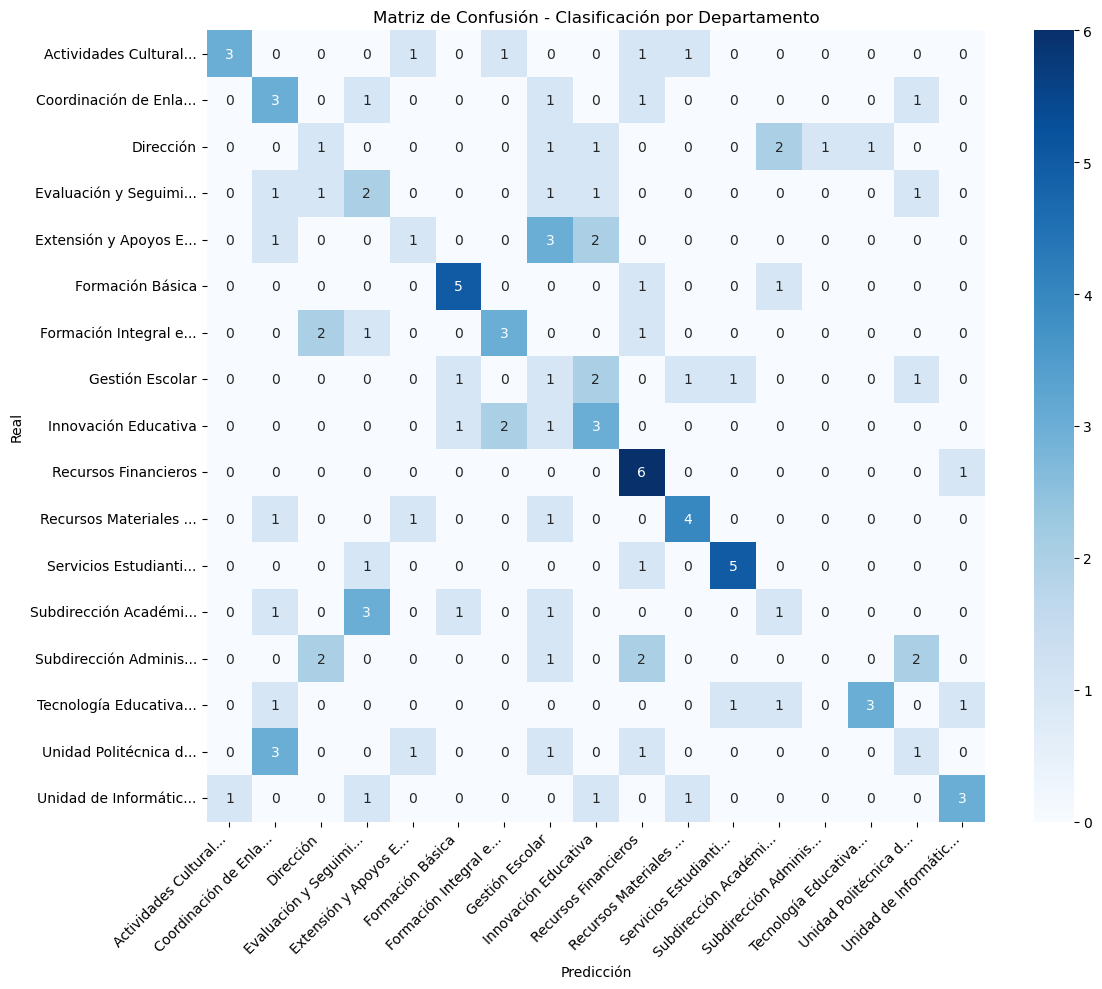

In [52]:
# Matriz de confusión
cm = confusion_matrix(y_true, y_pred)
labels_display = [l[:20] + "..." if len(l) > 20 else l for l in label2id.keys()]

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    xticklabels=labels_display,
    yticklabels=labels_display
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión - Clasificación por Departamento")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 7. Umbral de Confianza con Similitud Coseno

Para detectar comentarios **fuera de distribución (OOD)** o ambiguos, calculamos la similitud coseno entre el embedding del comentario y los embeddings de las anclas de cada departamento.

Si la máxima similitud está por debajo del umbral, el comentario se marca para **revisión humana**.

In [ ]:
# Obtener el encoder del modelo SetFit
sentence_encoder = model.model_body

# Generar embeddings de las anclas (descripciones de departamentos)
anclas_filtradas = {k: v for k, v in anclas.items() if k in label2id}
anclas_textos = list(anclas_filtradas.values())
anclas_labels = list(anclas_filtradas.keys())

# Codificar anclas
anclas_embeddings = sentence_encoder.encode(anclas_textos, convert_to_numpy=True)

print(f"🎯 Anclas codificadas: {anclas_embeddings.shape}")

# Umbral de confianza (ajustar según necesidades)
UMBRAL_CONFIANZA = 0.35

def calcular_similitud_anclas(texto):
    """
    Calcula la similitud coseno entre un texto y todas las anclas.
    Retorna (departamento_mas_similar, similitud_maxima, todas_similitudes)
    """
    embedding = sentence_encoder.encode([texto], convert_to_numpy=True)
    similitudes = cosine_similarity(embedding, anclas_embeddings)[0]
    
    idx_max = np.argmax(similitudes)
    return anclas_labels[idx_max], similitudes[idx_max], dict(zip(anclas_labels, similitudes))

# Prueba
texto_prueba = "El maestro de matemáticas falta mucho a clases"
dept, sim, todas = calcular_similitud_anclas(texto_prueba)
print(f"\n📝 Texto: '{texto_prueba}'")
print(f"   Departamento más similar: {dept}")
print(f"   Similitud: {sim:.4f}")
print(f"   ¿Confiable? {'✅ Sí' if sim >= UMBRAL_CONFIANZA else '⚠️ Requiere revisión'}")

## 8. Pipeline de Inferencia Completo

El pipeline combina las tres capas:
1. **FlashText** → Clasificación instantánea por palabras clave
2. **SetFit** → Clasificación semántica con el modelo entrenado  
3. **Umbral coseno** → Detección de incertidumbre para revisión humana

In [ ]:
def clasificar_comentario(texto, umbral=UMBRAL_CONFIANZA, usar_flashtext=True):
    """
    Pipeline completo de clasificación por departamento.
    
    Args:
        texto: Comentario a clasificar
        umbral: Umbral mínimo de similitud coseno para aceptar predicción
        usar_flashtext: Si True, intenta clasificar primero por palabras clave
    
    Returns:
        dict con:
            - departamento: Departamento predicho
            - confianza: Nivel de confianza (0-1)
            - metodo: "flashtext", "setfit" o "revision_humana"
            - similitudes: Dict con similitudes a cada departamento
    """
    resultado = {
        "texto": texto,
        "departamento": None,
        "confianza": 0.0,
        "metodo": None,
        "similitudes": {}
    }
    
    # Capa 1: FlashText (palabras clave)
    if usar_flashtext:
        dept_kw, conf_kw = clasificar_por_keywords(texto)
        if dept_kw:
            resultado["departamento"] = dept_kw
            resultado["confianza"] = conf_kw
            resultado["metodo"] = "flashtext"
            return resultado
    
    # Capa 2: SetFit + verificación con similitud coseno
    pred_idx = model.predict([texto])[0]
    pred_label = id2label[pred_idx]
    
    # Calcular similitud con anclas
    dept_ancla, sim_max, todas_sims = calcular_similitud_anclas(texto)
    resultado["similitudes"] = todas_sims
    
    # Capa 3: Verificar confianza
    if sim_max >= umbral:
        resultado["departamento"] = pred_label
        resultado["confianza"] = float(sim_max)
        resultado["metodo"] = "setfit"
    else:
        resultado["departamento"] = pred_label
        resultado["confianza"] = float(sim_max)
        resultado["metodo"] = "revision_humana"
    
    return resultado

# Ejemplo de uso
print("🔬 Ejemplos de clasificación:\n")
ejemplos = [
    "El aire acondicionado del laboratorio no funciona desde hace una semana",
    "Necesito una constancia de estudios para una beca",
    "El profesor de cálculo explica muy bien, felicidades",
    "La comida de la cafetería está muy cara",
    "xyz abc 123"  # Texto sin sentido para probar OOD
]

for ejemplo in ejemplos:
    res = clasificar_comentario(ejemplo)
    print(f"📝 '{ejemplo[:60]}...' " if len(ejemplo) > 60 else f"📝 '{ejemplo}'")
    print(f"   → {res['departamento']}")
    print(f"   → Confianza: {res['confianza']:.2f} | Método: {res['metodo']}")
    print()

## 9. Exportación ONNX con Cuantización INT8

Exportamos el modelo a ONNX para inferencia optimizada. La cuantización INT8 reduce el tamaño ~4x y acelera ~3x en CPU.

In [ ]:
import os

# Crear directorio para modelos
models_dir = carpeta_raiz / "models"
os.makedirs(models_dir, exist_ok=True)

# Guardar modelo SetFit completo
model_path = models_dir / "clasificador_departamentos_setfit"
model.save_pretrained(str(model_path))
print(f"✅ Modelo SetFit guardado en: {model_path}")

# Guardar mapeos de etiquetas
import json
mapeos = {
    "label2id": label2id,
    "id2label": id2label,
    "anclas": anclas_filtradas,
    "umbral_confianza": UMBRAL_CONFIANZA
}
with open(models_dir / "clasificador_departamentos_config.json", "w", encoding="utf-8") as f:
    json.dump(mapeos, f, ensure_ascii=False, indent=2)
print(f"✅ Configuración guardada en: {models_dir / 'clasificador_departamentos_config.json'}")

In [ ]:
# Exportar encoder a ONNX (opcional - requiere optimum instalado)
try:
    from optimum.onnxruntime import ORTModelForFeatureExtraction
    from optimum.onnxruntime.configuration import AutoQuantizationConfig
    from optimum.onnxruntime import ORTQuantizer
    
    # Exportar a ONNX
    onnx_path = models_dir / "clasificador_encoder_onnx"
    
    # Guardar el modelo base del encoder para exportación
    sentence_encoder.save(str(onnx_path / "sentence_transformer"))
    
    print(f"✅ Encoder guardado para exportación ONNX en: {onnx_path}")
    print("\n💡 Para cuantización INT8, ejecuta desde terminal:")
    print(f"   optimum-cli export onnx --model {onnx_path / 'sentence_transformer'} {onnx_path / 'onnx'}")
    print(f"   optimum-cli onnxruntime quantize --onnx_model {onnx_path / 'onnx'} -o {onnx_path / 'onnx_int8'}")
    
except ImportError:
    print("⚠️ 'optimum' no instalado. Para exportar ONNX ejecuta:")
    print("   pip install optimum[onnxruntime]")
    print("\n💾 El modelo SetFit fue guardado y puede usarse directamente.")

## 10. Función de Carga y Uso del Modelo Guardado

Función reutilizable para cargar el modelo entrenado en producción.

In [ ]:
def cargar_clasificador(modelo_path, config_path):
    """
    Carga el clasificador de departamentos entrenado.
    
    Args:
        modelo_path: Ruta al modelo SetFit guardado
        config_path: Ruta al archivo de configuración JSON
    
    Returns:
        Tupla (modelo, config) lista para usar
    """
    # Cargar modelo
    modelo = SetFitModel.from_pretrained(modelo_path)
    
    # Cargar configuración
    with open(config_path, "r", encoding="utf-8") as f:
        config = json.load(f)
    
    return modelo, config

# Ejemplo de uso (descomentar para probar)
# modelo_cargado, config_cargada = cargar_clasificador(
#     models_dir / "clasificador_departamentos_setfit",
#     models_dir / "clasificador_departamentos_config.json"
# )
# print("✅ Modelo cargado exitosamente")

print("📦 Para usar el modelo en otro script:")
print("""
from setfit import SetFitModel
import json

# Cargar
model = SetFitModel.from_pretrained("../models/clasificador_departamentos_setfit")
with open("../models/clasificador_departamentos_config.json") as f:
    config = json.load(f)

# Predecir
prediccion = model.predict(["Mi comentario aquí"])[0]
departamento = config["id2label"][str(prediccion)]
print(f"Departamento: {departamento}")
""")

## Resumen

Este notebook implementa un sistema de clasificación de comentarios por departamento usando:

| Componente | Función | Ventaja |
|------------|---------|---------|
| **FlashText** | Pre-filtrado por palabras clave | O(n), instantáneo |
| **SetFit** | Clasificación semántica Few-Shot | Funciona con pocos ejemplos |
| **Anchoring** | Descripciones como anclas semánticas | Mejora generalización |
| **Umbral Coseno** | Detección de incertidumbre | Evita errores silenciosos |
| **ONNX (opcional)** | Inferencia optimizada | 3-4x más rápido en CPU |

### Artefactos generados:
- `../models/clasificador_departamentos_setfit/` - Modelo entrenado
- `../models/clasificador_departamentos_config.json` - Configuración y mapeos